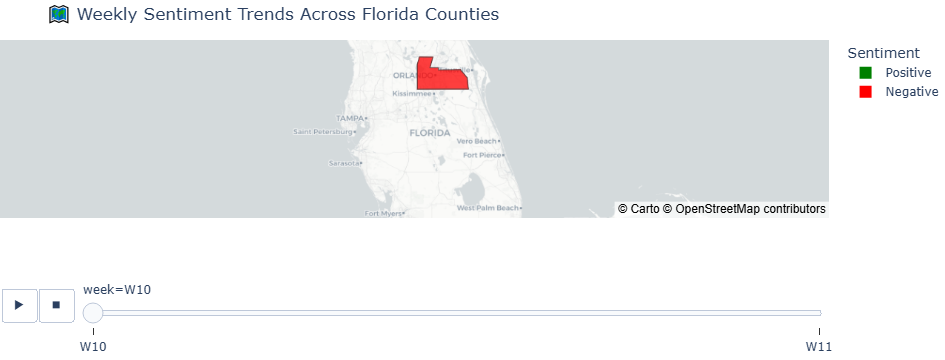

In [3]:
import pandas as pd
import plotly.express as px
import requests

# Load your actual df here
# df = pd.read_csv("your_file.csv")
# Simulated test df for structure
df = pd.DataFrame({
    'county_name': ['miami-dade', 'miami-dade', 'orange', 'orange'],
    'MMWR_WEEK': [10, 11, 10, 11],
    'Sentiments_pat_ana': ['Positive', 'Neutral', 'Negative', 'Positive']
})

# Cleanup
df['county_name'] = df['county_name'].str.lower()
df['MMWR_WEEK'] = pd.to_numeric(df['MMWR_WEEK'], errors='coerce')
df = df[df['MMWR_WEEK'] > 0]

# Week formatting
week_map = {w: f"W{int(w):02}" for w in sorted(df['MMWR_WEEK'].unique())}
df['week'] = df['MMWR_WEEK'].map(week_map)

# Full county-week grid
all_weeks = sorted(df['MMWR_WEEK'].unique())
all_counties = sorted(df['county_name'].unique())
full_index = pd.MultiIndex.from_product([all_counties, all_weeks], names=['county_name', 'MMWR_WEEK'])
df_full = pd.DataFrame(index=full_index).reset_index()
df_full['week'] = df_full['MMWR_WEEK'].map(week_map)

# Merge most common sentiment
agg_df = df.groupby(['county_name', 'MMWR_WEEK'])['Sentiments_pat_ana'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
df_full = df_full.merge(agg_df, on=['county_name', 'MMWR_WEEK'], how='left')

# Forward fill
df_full['Sentiments Trends'] = df_full.groupby('county_name')['Sentiments_pat_ana'].ffill()
df_full['Sentiments Trends'] = pd.Categorical(df_full['Sentiments Trends'], categories=["Positive", "Neutral", "Negative"], ordered=True)

# Florida GeoJSON
url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
geojson = requests.get(url).json()
florida_geo = {
    "type": "FeatureCollection",
    "features": [f for f in geojson["features"] if f["properties"]["STATE"] == "12"]
}
for f in florida_geo["features"]:
    f["properties"]["county_name"] = f["properties"]["NAME"].lower()

# Color map
sentiment_colors = {"Positive": "green", "Neutral": "blue", "Negative": "red"}

# Plot map
fig = px.choropleth_mapbox(
    df_full,
    geojson=florida_geo,
    locations='county_name',
    featureidkey="properties.county_name",
    color='Sentiments Trends',
    animation_frame='week',
    color_discrete_map=sentiment_colors,
    mapbox_style="carto-positron",
    center={"lat": 27.8, "lon": -81.7},
    zoom=5.5,
    opacity=0.75,
    title="🗺️ Weekly Sentiment Trends Across Florida Counties"
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0}, legend_title_text="Sentiment")
fig.show()
